## 1. Setup

In [2]:
# Better error messages in notebooks
%load_ext autoreload
%autoreload 2

In [1]:
# Set up data paths

import sys
from pathlib import Path

# Get to project root from notebook location
PROJECT_ROOT = Path.cwd().parent
# Add "src" to Python's module search path sys.path
sys.path.append(str(PROJECT_ROOT / "src"))

# Define project paths
DATA_DIR = PROJECT_ROOT / "data"
CONFIG_DIR = PROJECT_ROOT / "configs"
RUNS_DIR = PROJECT_ROOT / "runs"

print(f"PROJECT_ROOT: {PROJECT_ROOT}")
print(f"DATA_DIR: {DATA_DIR}")
print(f"CONFIG_DIR: {CONFIG_DIR}")
print(f"RUNS_DIR: {RUNS_DIR}")

PROJECT_ROOT: /home/peterm/UWA/CITS5014/SARFish/modelling
DATA_DIR: /home/peterm/UWA/CITS5014/SARFish/modelling/data
CONFIG_DIR: /home/peterm/UWA/CITS5014/SARFish/modelling/configs
RUNS_DIR: /home/peterm/UWA/CITS5014/SARFish/modelling/runs


In [4]:
# Setup and imports
%matplotlib inline
from sar_dataset import SARPreprocessedDataset
from letterbox_resize import letterbox_resize
from sar_yolo_simple_trainer import SimpleSARTrainer
from sar_evaluator import SARFloat32Evaluator
import json

In [5]:
# Create data configuration
import yaml

data_config = {
    'path':   str(PROJECT_ROOT / 'data'), 
    'train':  'train',
    'val':    'val', 
    'test':   'test',
    'nc': 2,
    'names':  ['is_vessel', 'is_fishing']
}

# Save to configs directory
config_path = CONFIG_DIR / 'sar_data.yaml'
with open(config_path, 'w') as f:
    yaml.dump(data_config, f)

## 2. Model Inspection (YOLOv8)

In [5]:
%run {PROJECT_ROOT / 'src/yolov8n_model_explorer'}

YOLOv8n Architecture Overview:
Module 0: model
  Contains 23 sub-modules
  Type: Sequential


Detailed Layer Analysis:
Total parameter tensors: 184
Total parameters: 3,157,200

First 50 parameter tensors:
  0: Module  0 | model.0.conv.weight                                          | shape=[16, 3, 3, 3] | params=432
  1: Module  0 | model.0.bn.weight                                            | shape=[16] | params=16
  2: Module  0 | model.0.bn.bias                                              | shape=[16] | params=16
  3: Module  1 | model.1.conv.weight                                          | shape=[32, 16, 3, 3] | params=4,608
  4: Module  1 | model.1.bn.weight                                            | shape=[32] | params=32
  5: Module  1 | model.1.bn.bias                                              | shape=[32] | params=32
  6: Module  2 | model.2.cv1.conv.weight                                      | shape=[32, 32, 1, 1] | params=1,024
  7: Module  2 | model.2.cv1.bn.weight

### Proposed Freezing Strategies:

For YOLOv8n fine-tuning on SAR data:

1. CONSERVATIVE (Freeze backbone only):  
   Freezes modules 0-9
   - Freezes: 1,272,656 parameters (40.3%)
   - Trains: 1,884,544 parameters (59.7%)  
2. MODERATE (Freeze backbone + early neck):  
   Freezes modules 0-12  
3. AGGRESSIVE (Freeze most, train detection head only):  
   Freezes modules 0-20

## 3. Model training

In [6]:
# Start TensorBoard in notebook
%load_ext tensorboard
%tensorboard --logdir {RUNS_DIR / 'train_no_aug'}

In [7]:
# Initialise trainer
trainer = SimpleSARTrainer(
    model_name='yolov8n.pt',
    data_yaml=str(CONFIG_DIR / 'sar_data.yaml'),
    imgsz=640,
    device='cuda',
    save_dir=RUNS_DIR / 'train_no_aug'
)

💾 Models will be saved to: /home/peterm/UWA/CITS5014/SARFish/modelling/runs/train_no_aug/20250722_152542
Using device: cuda
Train samples: 3114
Val samples: 463


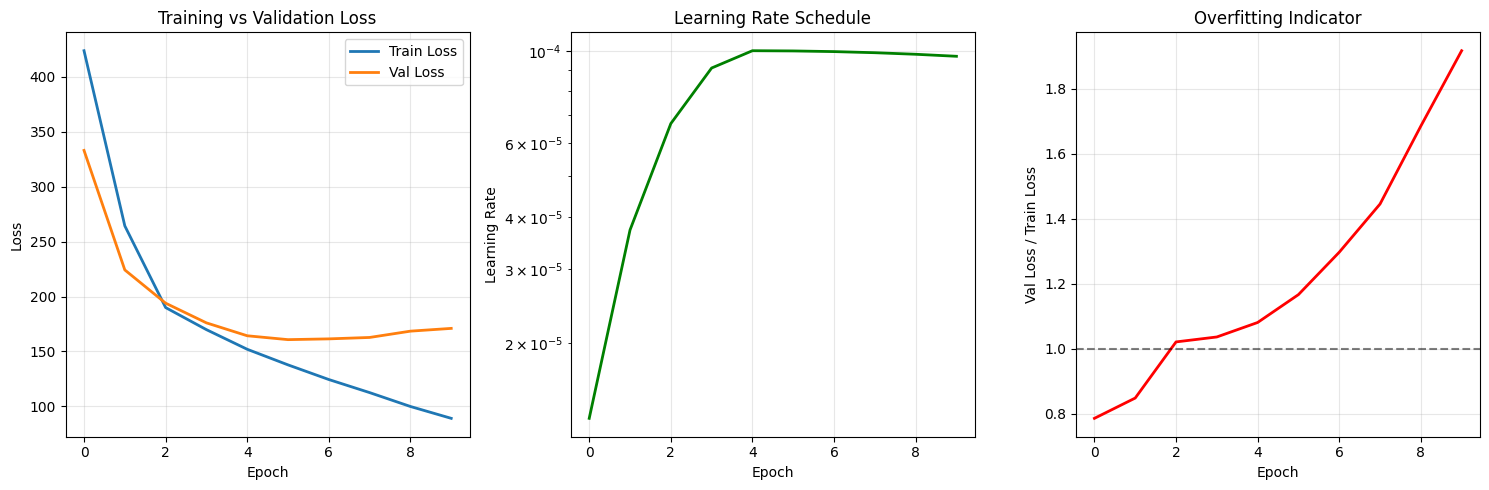

  💾 Saved checkpoint: epoch_10.pt

Epoch 11/50


Training:   0%|          | 0/195 [00:00<?, ?it/s]

Validation:   0%|          | 0/29 [00:00<?, ?it/s]


📊 Results:
  Train Loss: 80.4314
  Val Loss: 173.9758
  Learning Rate: 0.000096
  ⏳ Patience counter: 5/5

🛑 Early stopping triggered at epoch 11
  💾 Saved checkpoint: final.pt

Training completed!
Best validation loss: 160.7809
Final epoch: 11


In [8]:
# Train the model
history = trainer.train(
    epochs=50,  # Still testing
    batch_size=16,
    optimizer_type='adamw',
    lr=0.00001,
    workers=4,
    weight_decay=0.0005,  # L2 regularization
    use_warmup=True,  # Enable learning rate warmup
    use_progressive_unfreeze=False,  # Disable progressive unfreezing
    freeze_until_module=12  # Freeze backbone only
)

In [9]:
# Load best model
best_epoch, best_val_loss = trainer.load_best_model()
print(f"Loaded best model from epoch {best_epoch+1} with val loss {best_val_loss:.4f}")

Loaded best model from epoch 6
Loaded best model from epoch 6 with val loss 160.7809


In [10]:
# Save training history using the trainer's save_dir
with open(trainer.save_dir / 'history.json', 'w') as f:
    json.dump(history, f)

# Save training config
config = {
    'model_name': 'yolov8n.pt',
    'epochs': 50,
    'batch_size': 16,
    'optimizer_type': 'adamw',
    'lr': 0.00001,
    'workers': 4,
    'weight_decay': 0.0005,
    'use_warmup': True,
    'use_progressive_unfreeze': False,
    'freeze_until_module': 9,
    'best_val_loss': trainer.best_val_loss,
    'final_epoch': len(history['train_loss']),
    'early_stopped': trainer.patience_counter >= trainer.early_stop_patience
}

with open(trainer.save_dir / 'config.json', 'w') as f:
    json.dump(config, f, indent=2)

print(f"✅ Saved training history and config to: {trainer.save_dir}")

✅ Saved training history and config to: /home/peterm/UWA/CITS5014/SARFish/modelling/runs/train_no_aug/20250722_152542


## 4. Model Evaluation

In [ ]:
# Sets up path to data.yaml file for easy access
config_path=CONFIG_DIR /'sar_data.yaml' 
print(config_path)

In [ ]:
# Initialize the evaluator
evaluator = SARFloat32Evaluator(
    model_path=RUNS_DIR / 'train_no_aug/20250721_130953/best.pt',
    data_yaml_path=config_path,
    device='cuda'
)

In [ ]:
# Create the test dataset
with open(config_path, 'r') as f:
    data_dict = yaml.safe_load(f)

# Create test dataset manually
data_root = Path(data_dict['path'])
test_dataset = SARPreprocessedDataset(
    image_dir=str(data_root / 'test' / 'images'),  # or 'test' if using test
    label_dir=str(data_root / 'test' / 'labels'),
    imgsz=640
)

In [ ]:
# Run evaluation
metrics = evaluator.evaluate_dataset(
    test_dataset,
    batch_size=32,
    conf_thres=0.25,
    iou_thres=0.45,
    save_dir=RUNS_DIR / 'evaluation_no_aug' / 'test_results'
)

In [ ]:
# Test inference on a single image
import torch
import numpy as np

# Load a test image
test_img_path = list((DATA_DIR / 'test' / 'images').glob('*.npy'))[0]
print(test_img_path)
test_img = np.load(test_img_path)

# Convert numpy image to a torch tensor and add a batch dimension with
# unsqueeze, then move the tensor to the approriate device (CPU or GPU)
test_img = torch.from_numpy(test_img).unsqueeze(0).to(trainer.device)

# Run inference
trainer.model.eval() # Sets the model to evaluation mode (disables dropout, uses running stats for batch normalization)
with torch.no_grad(): # Disables gradient computation for efficiency during inference
    predictions = trainer.model(test_img)

# Print the shape of predictions—taking care to handle tuple output (like in YOLO-style heads).    
print(f"Predictions shape: {predictions[1][0].shape if isinstance(predictions, tuple) else predictions.shape}")